In [1]:
import cv2 
import os
import matplotlib.pylab as plt
import pandas as pd
import glob
import numpy as np

In [208]:
import ConcurrentImageRead as CIR


In [121]:
Main_Path=os.getcwd()

In [210]:
All_images=[]
labels=[]
for class_name in os.listdir(os.path.join(Main_Path, 'traffic_Data/DATA')):
    if class_name != '.DS_Store':
        class_path = os.path.join(Main_Path, f'traffic_Data/DATA/{class_name}')
        images = CIR.read_dir(class_path,file_type='png', num_threads=3, channel_type='RGB', sub_dir=False,resize=(100,100))
        y_class=[class_name]*len(images)
        All_images.append(images)
        labels.append(y_class)
    

            

In [211]:
import itertools
All_images=list(itertools.chain.from_iterable(All_images))
labels=list(itertools.chain.from_iterable(labels))

In [212]:
def Image_Flatten(im):
    return im.flatten()
    
    

In [213]:
All_images=list(map(Image_Flatten, All_images))

In [ ]:
All_images_Data_Frame=pd.DataFrame(All_images)
labels_data_frame=pd.DataFrame(labels,columns=['Classes'])

In [ ]:
All_images_Data_Frame.shape,labels_data_frame.shape

((4170, 30000), (4170, 1))

In [ ]:
IMAGE_DATA=pd.concat([All_images_Data_Frame,labels_data_frame],axis=1)

# Augmentation

In [ ]:
Original_label=pd.read_csv('labels.csv')
Original_label['ClassId']=Original_label['ClassId'].astype('int8')
Original_label['Name'] = Original_label['Name'].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [ ]:
IMAGE_DATA['Classes']=IMAGE_DATA['Classes'].astype('int8')

In [ ]:
IMAGE_DATA=IMAGE_DATA.merge(Original_label,left_on='Classes',right_on='ClassId',how='left')

In [ ]:
def remove_unknow(name):
    return name.startswith('unknown')

In [ ]:
IMAGE_DATA_KNOWN=IMAGE_DATA[~IMAGE_DATA['Name'].apply(remove_unknow)].reset_index(inplace=False, drop=True)

In [ ]:
unique_names = IMAGE_DATA_KNOWN['Name'].unique()

# Create a dictionary to map unique names to new Class IDs
new_class_ids = {name: idx for idx, name in enumerate(unique_names)}

# Create a new column 'New_ClassID' based on the mapping
IMAGE_DATA_KNOWN['New_ClassID'] = IMAGE_DATA_KNOWN['Name'].map(new_class_ids)

# Display the DataFrame with the new column


In [ ]:
data_dict = {'keys': list(new_class_ids.keys()),
             'values': list(new_class_ids.values())}


In [ ]:
pd.DataFrame(data_dict).to_csv('Transformation.csv')

In [ ]:
def is_direction(name):
    direction = ['right', 'left', 'straight']
    return any(d in name for d in direction)

filtered_data_without_direction = IMAGE_DATA_KNOWN[~IMAGE_DATA_KNOWN['Name'].apply(is_direction)].reset_index(inplace=False, drop=True)
filtered_data_with_direction = IMAGE_DATA_KNOWN[IMAGE_DATA_KNOWN['Name'].apply(is_direction)].reset_index(inplace=False, drop=True)

In [ ]:
X_Train_without_direction=filtered_data_without_direction.drop(['Classes','ClassId','Name','New_ClassID'],axis=1)
X_Train_with_direction=filtered_data_with_direction.drop(['Classes','ClassId','Name','New_ClassID'],axis=1)
Y_train_without_direction=filtered_data_without_direction['New_ClassID']
Y_train_with_direction=filtered_data_with_direction['New_ClassID']



In [2]:
import tensorflow as tf
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 20,
        horizontal_flip = True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode='nearest',
)


In [ ]:
X_Train_without_direction_image_array = X_Train_without_direction.to_numpy()
# Reshape the flattened images back into their original shapes
original_shape = (100, 100, 3)  # Define the original shape of the images
num_images = X_Train_without_direction_image_array.shape[0]
X_Train_without_direction_reshaped_images = X_Train_without_direction_image_array.reshape(num_images, *original_shape)
X_Train_without_direction_reshaped_images=X_Train_without_direction_reshaped_images.astype('uint8')/255


In [ ]:
X_Train_without_direction_reshaped_images.shape

(2926, 100, 100, 3)

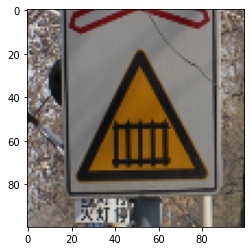

In [ ]:
plt.imshow(X_Train_without_direction_reshaped_images[0])

In [ ]:
generator=datagen.flow(X_Train_without_direction_reshaped_images,Y_train_without_direction)

In [ ]:
i=0
images_augmented=[]
y_for_augmented_image=[]
while i<200:
    im,l=generator.next()
    # im=im.astype('uint8') / 255
    images_augmented.append(im)
    y_for_augmented_image.append(l)
    i+=1

/Users/amitprajapati/tensorflow-test/env/lib/python3.8/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/amitprajapati/tensorflow-test/env/lib/python3.8/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
images_augmented=np.concatenate(images_augmented)
y_for_augmented_image=np.concatenate(y_for_augmented_image)

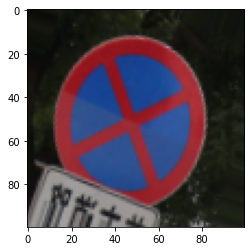

In [ ]:
plt.imshow(images_augmented[1000])

In [ ]:
FINAL_X_TRAIN_WITHOUT_DIRECTION = np.concatenate((X_Train_without_direction_reshaped_images, images_augmented), axis=0)
FINAL_Y_TRAIN_WITHOUT_DIRECTION = np.concatenate((Y_train_without_direction, y_for_augmented_image), axis=0)


In [ ]:
np.save('FINAL_X_TRAIN_WITHOUT_DIRECTION',FINAL_X_TRAIN_WITHOUT_DIRECTION)

In [ ]:
np.save('FINAL_Y_TRAIN_WITHOUT_DIRECTION',FINAL_Y_TRAIN_WITHOUT_DIRECTION)

In [ ]:
FINAL_X_TRAIN_WITHOUT_DIRECTION=None
FINAL_Y_TRAIN_WITHOUT_DIRECTION=None


In [ ]:
# FINAL_X_TRAIN_WITHOUT_DIRECTION.shape,FINAL_Y_TRAIN_WITHOUT_DIRECTION.shape

In [ ]:
datagen_with_direction= ImageDataGenerator(
        rotation_range = 20,
        # horizontal_flip = True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode='nearest',
)



In [ ]:
X_Train_with_direction_image_array = X_Train_with_direction.to_numpy()

# Reshape the flattened images back into their original shapes
original_shape = (100, 100, 3)  # Define the original shape of the images
num_images = X_Train_with_direction_image_array.shape[0]
X_Train_with_direction_reshaped_images = X_Train_with_direction_image_array.reshape(num_images, *original_shape)
X_Train_with_direction_reshaped_images=X_Train_with_direction_reshaped_images.astype('uint8')/255

In [ ]:
generator=datagen_with_direction.flow(X_Train_with_direction_reshaped_images,Y_train_with_direction)

In [ ]:
i=0
images_augmented_direction=[]
y_for_augmented_image_direction=[]
while i<200:
    im,l=generator.next()
    # im=im.astype('uint8') / 255
    images_augmented_direction.append(im)
    y_for_augmented_image_direction.append(l)
    i+=1

/Users/amitprajapati/tensorflow-test/env/lib/python3.8/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/amitprajapati/tensorflow-test/env/lib/python3.8/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
images_augmented_direction=np.concatenate(images_augmented_direction)
y_for_augmented_image_direction=np.concatenate(y_for_augmented_image_direction)

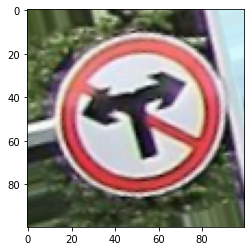

In [ ]:
plt.imshow(images_augmented_direction[343])

In [ ]:
FINAL_X_TRAIN_WITH_DIRECTION = np.concatenate((X_Train_with_direction_reshaped_images, images_augmented_direction), axis=0)
FINAL_Y_TRAIN_WITH_DIRECTION = np.concatenate((Y_train_with_direction, y_for_augmented_image_direction), axis=0)


In [ ]:
FINAL_X_TRAIN_WITH_DIRECTION.shape

(7248, 100, 100, 3)

In [ ]:
np.save('FINAL_X_TRAIN_WITH_DIRECTION',FINAL_X_TRAIN_WITH_DIRECTION)
np.save('FINAL_Y_TRAIN_WITH_DIRECTION',FINAL_Y_TRAIN_WITH_DIRECTION)

In [3]:
FINAL_X_TRAIN_WITH_DIRECTION=np.load('FINAL_X_TRAIN_WITH_DIRECTION.npy')
FINAL_X_TRAIN_WITHOUT_DIRECTION=np.load('FINAL_X_TRAIN_WITHOUT_DIRECTION.npy')
FINAL_Y_TRAIN_WITH_DIRECTION=np.load('FINAL_Y_TRAIN_WITH_DIRECTION.npy',allow_pickle=True)
FINAL_Y_TRAIN_WITHOUT_DIRECTION=np.load('FINAL_Y_TRAIN_WITHOUT_DIRECTION.npy',allow_pickle=True)

<h3> MODELLING

In [4]:
from keras.utils import to_categorical


In [5]:
X=np.concatenate((FINAL_X_TRAIN_WITH_DIRECTION,FINAL_X_TRAIN_WITHOUT_DIRECTION), axis=0)
Y=np.concatenate((FINAL_Y_TRAIN_WITH_DIRECTION,FINAL_Y_TRAIN_WITHOUT_DIRECTION),axis=0)

In [7]:
Y=to_categorical(Y)

In [6]:
FINAL_X_TRAIN_WITH_DIRECTION=None
FINAL_X_TRAIN_WITHOUT_DIRECTION=None
FINAL_Y_TRAIN_WITH_DIRECTION=None
FINAL_Y_TRAIN_WITHOUT_DIRECTION=None

In [8]:
X.shape,Y.shape

((16538, 100, 100, 3), (16538, 47))

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

In [10]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11576, 100, 100, 3)
(4962, 100, 100, 3)
(11576, 47)
(4962, 47)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,  MaxPool2D
from keras.callbacks import EarlyStopping

In [12]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Flatten())
model.add(Dense(47, activation='softmax'))

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    lr=0.001,
), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
ec_cnn = EarlyStopping(monitor='loss',patience=3)

cnn=model.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=ec_cnn)

Epoch 1/30



362/362 [==============================] - 98s 267ms/step - loss: 0.9087 - accuracy: 0.7458 - val_loss: 0.1854 - val_accuracy: 0.9401
Epoch 2/30
362/362 [==============================] - 95s 262ms/step - loss: 0.0994 - accuracy: 0.9719 - val_loss: 0.0400 - val_accuracy: 0.9879
Epoch 3/30
362/362 [==============================] - 97s 267ms/step - loss: 0.0480 - accuracy: 0.9862 - val_loss: 0.0436 - val_accuracy: 0.9865
Epoch 4/30
362/362 [==============================] - 96s 265ms/step - loss: 0.0217 - accuracy: 0.9945 - val_loss: 0.0162 - val_accuracy: 0.9962
Epoch 5/30
362/362 [==============================] - 94s 260ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0061 - val_accuracy: 0.9988
Epoch 6/30
362/362 [==============================] - 95s 262ms/step - loss: 1.3525e-04 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9986
Epoch 7/30
362/362 [==============================] - 116s 321ms/step - loss: 5.2548e-05 - accuracy: 1.0000 - val_loss: 0.0059 - val_accu

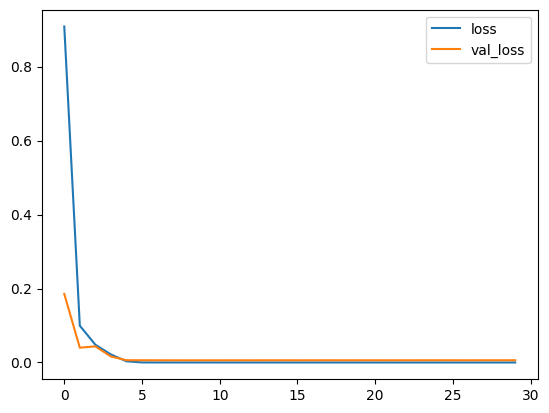

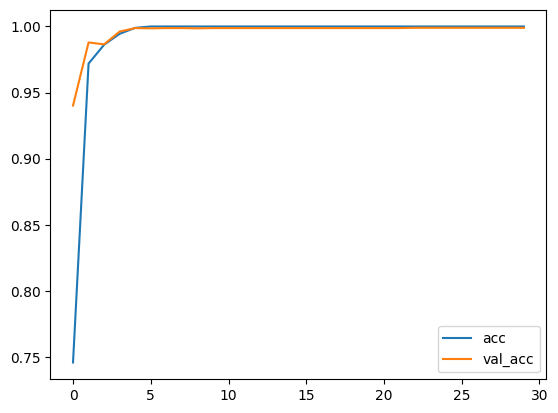

In [15]:
plt.plot(cnn.history['loss'], label='loss')
plt.plot(cnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(cnn.history['accuracy'], label='acc')
plt.plot(cnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [16]:
prediction=model.predict(x_test)

156/156 [==============================] - 12s 75ms/step


In [17]:
prediction=np.argmax(prediction,axis=1)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(prediction, np.argmax(y_test,axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00       154
           3       1.00      1.00      1.00         7
           4       0.96      1.00      0.98        22
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00        43
           7       1.00      1.00      1.00       256
           8       1.00      1.00      1.00        28
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00       116
          11       1.00      1.00      1.00       343
          12       1.00      1.00      1.00       151
          13       1.00      1.00      1.00        47
          14       1.00      0.99      0.99       139
          15       1.00      1.00      1.00        66
          16       1.00      1.00      1.00       423
          17       0.98    

***VGG***

In [24]:
vgg = Sequential()
vgg.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
vgg.add(Conv2D(64, kernel_size=3, activation='relu'))
vgg.add(MaxPool2D(pool_size=(2,2),strides=2))
vgg.add(Conv2D(128, kernel_size=3, activation='relu'))
vgg.add(Conv2D(128, kernel_size=3, activation='relu'))
vgg.add(MaxPool2D(pool_size=(2,2),strides=2))
vgg.add(Conv2D(256, kernel_size=3, activation='relu'))
vgg.add(Conv2D(256, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(MaxPool2D(pool_size=(2,2),strides=2))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Flatten())
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dense(47, activation='softmax'))

In [25]:
vgg.compile(optimizer=tf.keras.optimizers.Adam(
    lr=0.001,
), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
es = EarlyStopping(monitor='loss')
History=vgg.fit(x_train, y_train, epochs=30,validation_data=(x_test, y_test),batch_size=32,callbacks=es)

Epoch 1/30
362/362 [==============================] - 729s 2s/step - loss: 3.4256 - accuracy: 0.0821 - val_loss: 3.4098 - val_accuracy: 0.0852
Epoch 2/30
362/362 [==============================] - 735s 2s/step - loss: 3.4218 - accuracy: 0.0825 - val_loss: 3.4082 - val_accuracy: 0.0852
Epoch 3/30
362/362 [==============================] - 800s 2s/step - loss: 3.4186 - accuracy: 0.0853 - val_loss: 3.4077 - val_accuracy: 0.0852
Epoch 4/30
362/362 [==============================] - 830s 2s/step - loss: 3.4159 - accuracy: 0.0853 - val_loss: 3.4117 - val_accuracy: 0.0852
Epoch 5/30
362/362 [==============================] - 787s 2s/step - loss: 3.4140 - accuracy: 0.0827 - val_loss: 3.4089 - val_accuracy: 0.0852
Epoch 6/30
362/362 [==============================] - 736s 2s/step - loss: 3.4139 - accuracy: 0.0853 - val_loss: 3.4044 - val_accuracy: 0.0852
Epoch 7/30
362/362 [==============================] - 1096s 3s/step - loss: 3.4131 - accuracy: 0.0853 - val_loss: 3.4062 - val_accuracy: 0.085

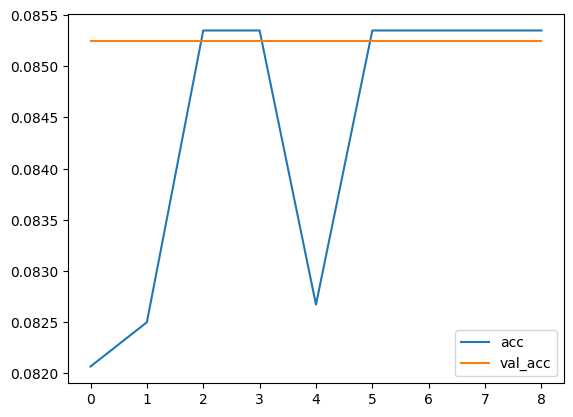

In [28]:
plt.plot(History.history['accuracy'], label='acc')
plt.plot(History.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [29]:
vgg_prediction=vgg.predict(x_test)
vgg_prediction=np.argmax(vgg_prediction,axis=1)

156/156 [==============================] - 50s 317ms/step


In [30]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),vgg_prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00       154
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        43
           7       0.00      0.00      0.00       255
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00       116
          11       0.00      0.00      0.00       343
          12       0.00      0.00      0.00       151
          13       0.00      0.00      0.00        47
          14       0.00      0.00      0.00       137
          15       0.00      0.00      0.00        66
          16       0.09      1.00      0.16       423
          17       0.00    

c:\Users\Atharva Kulkarni\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Atharva Kulkarni\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Atharva Kulkarni\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

***PCA***

In [10]:
X_for_PCA=X.reshape(16538,30000)

In [11]:
from sklearn.decomposition import PCA
Images_pca = PCA(n_components=200)

In [12]:
Images_pca.fit(X_for_PCA)
Transformed_images = Images_pca.transform(X_for_PCA)

In [13]:
import pickle as pk

In [14]:
pk.dump(Images_pca, open("pca.pkl","wb"))


In [15]:
print(f"Variance Captured my the 1st 10 principal components : {sum(Images_pca.explained_variance_ratio_)}")

Variance Captured my the 1st 10 principal components : 0.9090984252509668


In [16]:
Eigen_faces=Images_pca.inverse_transform(Transformed_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


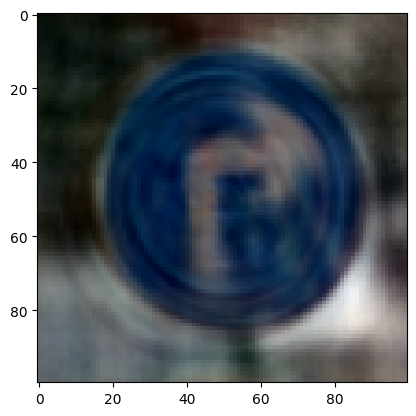

In [17]:
plt.imshow(Eigen_faces[643].reshape(100,100,3))


In [18]:
# from sklearn import preprocessing 
# label_encoder = preprocessing.LabelEncoder() 
# Y= label_encoder.fit_transform(Y) 



In [19]:
X_for_PCA_transformed=Eigen_faces.reshape(16538,100,100,3)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,  MaxPool2D
from keras.callbacks import EarlyStopping


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_for_PCA_transformed, Y, test_size=0.4, random_state=42)

In [22]:
X=None
Y=None

In [23]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((9922, 100, 100, 3), (6616, 100, 100, 3), (9922,), (6616,))

In [24]:
X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.20, random_state=42)

In [25]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_val.shape,y_val.shape

((9922, 100, 100, 3),
 (5292, 100, 100, 3),
 (9922,),
 (5292,),
 (1324, 100, 100, 3),
 (1324,))

In [26]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)

In [27]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_val.shape,y_val.shape

((9922, 100, 100, 3),
 (5292, 100, 100, 3),
 (9922, 47),
 (5292, 47),
 (1324, 100, 100, 3),
 (1324, 47))

In [28]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Flatten())
model.add(Dense(47, activation='softmax'))

In [29]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    lr=0.001,
), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
ec_cnn = EarlyStopping(monitor='loss',patience=3)

History_cnn=model.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),batch_size=32,callbacks=ec_cnn)

Epoch 1/30



311/311 [==============================] - 185s 569ms/step - loss: 1.0827 - accuracy: 0.6982 - val_loss: 0.3224 - val_accuracy: 0.8905
Epoch 2/30
311/311 [==============================] - 141s 453ms/step - loss: 0.1965 - accuracy: 0.9379 - val_loss: 0.1615 - val_accuracy: 0.9434
Epoch 3/30
311/311 [==============================] - 141s 455ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.1033 - val_accuracy: 0.9683
Epoch 4/30
311/311 [==============================] - 138s 443ms/step - loss: 0.0513 - accuracy: 0.9844 - val_loss: 0.1267 - val_accuracy: 0.9690
Epoch 5/30
311/311 [==============================] - 138s 445ms/step - loss: 0.0437 - accuracy: 0.9886 - val_loss: 0.0614 - val_accuracy: 0.9781
Epoch 6/30
311/311 [==============================] - 160s 514ms/step - loss: 0.0332 - accuracy: 0.9896 - val_loss: 0.1020 - val_accuracy: 0.9698
Epoch 7/30
311/311 [==============================] - 195s 629ms/step - loss: 0.0294 - accuracy: 0.9919 - val_loss: 0.0584 - val_accura

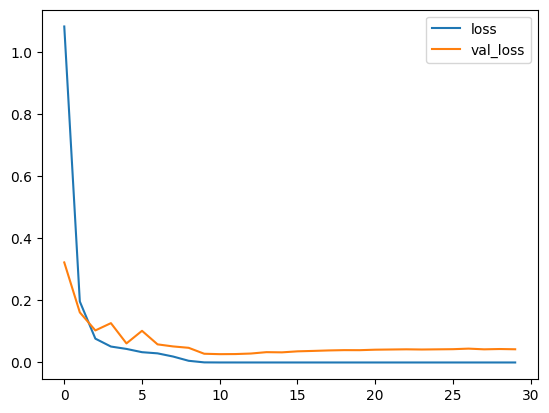

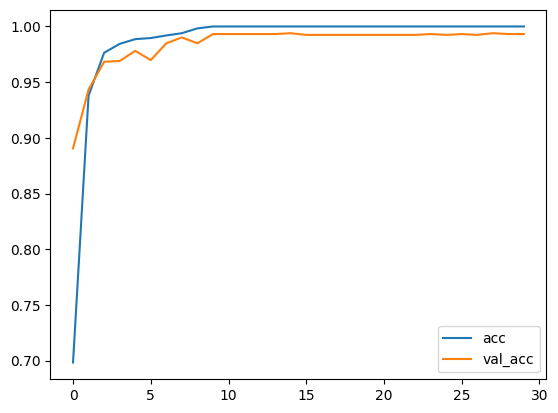

In [38]:

plt.plot(History_cnn.history['loss'], label='loss')
plt.plot(History_cnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(History_cnn.history['accuracy'], label='acc')
plt.plot(History_cnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [39]:
prediction=model.predict(X_test)

166/166 [==============================] - 13s 78ms/step


In [40]:
prediction=np.argmax(prediction,axis=1)

In [45]:
from sklearn.metrics import classification_report
report=classification_report(np.argmax(y_test,axis=1),prediction,target_names=pd.read_csv('Transformation.csv')['keys'].to_list(),output_dict=True)

In [54]:
report

{'fences': {'precision': 0.9807692307692307, 'recall': 1.0, 'f1-score': 0.9902912621359223, 'support': 51.0}, 'road divider': {'precision': 0.9411764705882353, 'recall': 0.8888888888888888, 'f1-score': 0.9142857142857143, 'support': 18.0}, 'zebra crossing': {'precision': 0.9931972789115646, 'recall': 0.9798657718120806, 'f1-score': 0.9864864864864865, 'support': 149.0}, 'heavy vehicle accidents': {'precision': 1.0, 'recall': 0.8888888888888888, 'f1-score': 0.9411764705882353, 'support': 9.0}, 'danger ahead': {'precision': 0.96, 'recall': 1.0, 'f1-score': 0.9795918367346939, 'support': 24.0}, 'traffic signals': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4.0}, 'go straight or right': {'precision': 0.9814814814814815, 'recall': 1.0, 'f1-score': 0.9906542056074766, 'support': 53.0}, 'speed limit (40km/h)': {'precision': 0.9885496183206107, 'recall': 1.0, 'f1-score': 0.9942418426103646, 'support': 259.0}, 'roundabout mandatory': {'precision': 1.0, 'recall'

In [ ]:
import seaborn as sns


<AxesSubplot:>

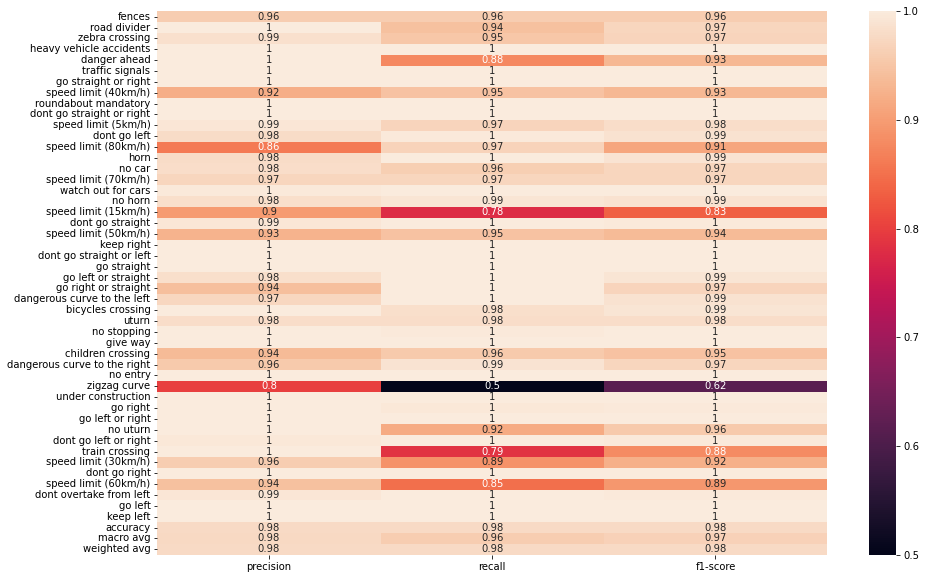

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)


In [ ]:
model.save('Model_pca_data.keras')

In [ ]:
new_model = tf.keras.models.load_model('Model_pca_data.keras')


In [ ]:

img=cv2.imread('/Users/amitprajapati/Documents/WPI_DOCS/Courses/ML/archive/traffic_Data/TEST/003_1_0021_1_j.png')


In [63]:
img=img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(100,100))

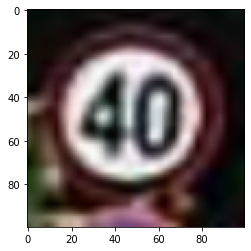

In [64]:
plt.imshow(img)

In [ ]:
pca_model=pk.load(open("pca.pkl",'rb'))

In [ ]:
img=img.reshape(1,100,100,3)/255

In [ ]:
img=pca_model.transform(img.reshape(1,30000))
img=pca_model.inverse_transform(img)

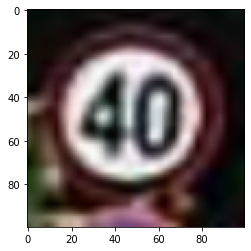

In [65]:
plt.imshow(img.reshape(100,100,3))

In [ ]:
np.argmax(new_model.predict(img.reshape(1,100,100,3)),axis=1)

1/1 [==============================] - 0s 20ms/step


array([20])

In [ ]:
pd.read_csv('Transformation.csv')

,Unnamed: 0,keys,values
0,0,fences,0
1,1,road divider,1
2,2,zebra crossing,2
3,3,heavy vehicle accidents,3
4,4,danger ahead,4
5,5,traffic signals,5
6,6,go straight or right,6
7,7,speed limit (40km/h),7
8,8,roundabout mandatory,8
9,9,dont go straight or right,9


In [13]:
import tensorflow as tf

In [47]:
#creating VGG-16 arc 

vgg = Sequential()
vgg.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
vgg.add(Conv2D(64, kernel_size=3, activation='relu'))
vgg.add(MaxPool2D(pool_size=(2,2),strides=2))
vgg.add(Conv2D(128, kernel_size=3, activation='relu'))
vgg.add(Conv2D(128, kernel_size=3, activation='relu'))
vgg.add(MaxPool2D(pool_size=(2,2),strides=2))
vgg.add(Conv2D(256, kernel_size=3, activation='relu'))
vgg.add(Conv2D(256, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(MaxPool2D(pool_size=(2,2),strides=2))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Conv2D(512, kernel_size=3, activation='relu'))
vgg.add(Flatten())
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dense(47, activation='softmax'))

# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(Conv2D(18, kernel_size=3, activation='relu'))
# model.add(Flatten())
# model.add(Dense(47, activation='softmax'))


In [48]:
vgg.compile(optimizer=tf.keras.optimizers.Adam(
    lr=0.001,
), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.4, random_state=42)

In [42]:
X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.2, random_state=42)

In [43]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)

In [44]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape,X_val.shape,y_val.shape

((9922, 100, 100, 3),
 (5292, 100, 100, 3),
 (9922, 47),
 (5292, 47),
 (1324, 100, 100, 3),
 (1324, 47))

In [50]:
es = EarlyStopping(monitor='loss',patience=3)
History=vgg.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),batch_size=32,callbacks=es)

Epoch 1/30
311/311 [==============================] - 452s 1s/step - loss: 0.6976 - accuracy: 0.7672 - val_loss: 0.6479 - val_accuracy: 0.7779
Epoch 2/30
311/311 [==============================] - 451s 1s/step - loss: 0.5577 - accuracy: 0.8115 - val_loss: 0.6217 - val_accuracy: 0.7931
Epoch 3/30
311/311 [==============================] - 451s 1s/step - loss: 0.4382 - accuracy: 0.8470 - val_loss: 0.4127 - val_accuracy: 0.8656
Epoch 4/30
311/311 [==============================] - 447s 1s/step - loss: 0.3506 - accuracy: 0.8803 - val_loss: 0.3738 - val_accuracy: 0.8852
Epoch 5/30
311/311 [==============================] - 453s 1s/step - loss: 0.2855 - accuracy: 0.9078 - val_loss: 0.2689 - val_accuracy: 0.9124
Epoch 6/30
311/311 [==============================] - 454s 1s/step - loss: 0.2320 - accuracy: 0.9219 - val_loss: 0.2879 - val_accuracy: 0.9026
Epoch 7/30
311/311 [==============================] - 447s 1s/step - loss: 0.2390 - accuracy: 0.9282 - val_loss: 0.1995 - val_accuracy: 0.9358

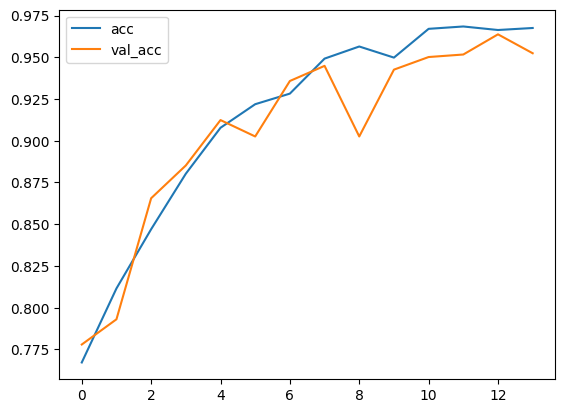

In [51]:

plt.plot(History.history['accuracy'], label='acc')
plt.plot(History.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()




In [52]:
vgg_prediction=vgg.predict(X_test)
vgg_prediction=np.argmax(vgg_prediction,axis=1)

166/166 [==============================] - 59s 341ms/step


In [53]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),vgg_prediction))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        51
           1       1.00      0.89      0.94        18
           2       0.95      0.94      0.94       149
           3       0.80      0.89      0.84         9
           4       0.86      1.00      0.92        24
           5       1.00      0.75      0.86         4
           6       0.95      1.00      0.97        53
           7       0.87      0.97      0.92       259
           8       1.00      1.00      1.00        30
           9       0.88      1.00      0.93         7
          10       0.96      0.95      0.96       136
          11       0.99      1.00      1.00       368
          12       0.93      0.92      0.92       154
          13       1.00      0.87      0.93        47
          14       0.99      0.90      0.94       159
          15       0.86      0.86      0.86        70
          16       0.96      1.00      0.98       443
          17       0.99    

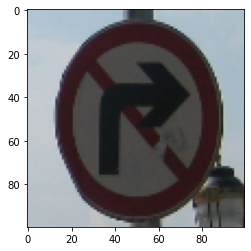

In [129]:

img=cv2.imread('/Users/amitprajapati/Documents/WPI_DOCS/Courses/ML/archive/traffic_Data/NEW_DATA/13/013_1_0006.png')
img=img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(100,100))
img=img.reshape(1,100,100,3)/255
plt.imshow(img.reshape(100,100,3))


In [130]:
d=pd.read_csv('Transformation.csv')
d[d['values']==np.argmax(vgg.predict(img),axis=1)[0]]


1/1 [==============================] - 0s 78ms/step


,Unnamed: 0,keys,values
42,42,dont go right,42


In [90]:
vgg.save('VGG_architecture.keras')

In [91]:
vgg_loadded = tf.keras.models.load_model('VGG_architecture.keras')


In [93]:
np.argmax(vgg_loadded.predict(img),axis=1)

1/1 [==============================] - 0s 115ms/step


array([38])